<font size=7> Remove Blue Arrows

# <font color="gray"> Setup

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs #, plot_vector_layout2, plot_vector_layout3
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

In [2]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/derived/kilosort2/Hc120523_aav9hckcr1_chip21769_121123_2_acqm.zip" )


In [4]:
# good_pairs = curate_latencies(sd)
# with open( 'curate_latencies_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
#load pickled data
with open( 'chip21769_acid_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)
print(len(good_pairs))

71


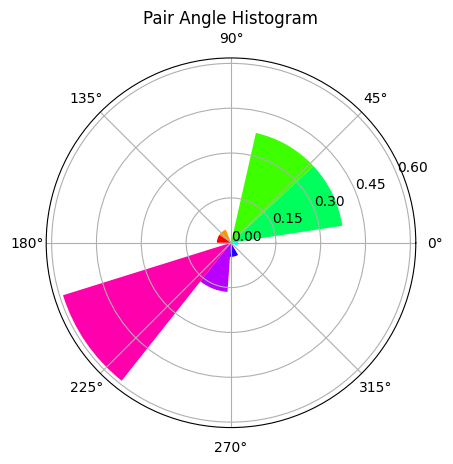

In [11]:
plot_latency_angle_hist( sd, good_pairs)

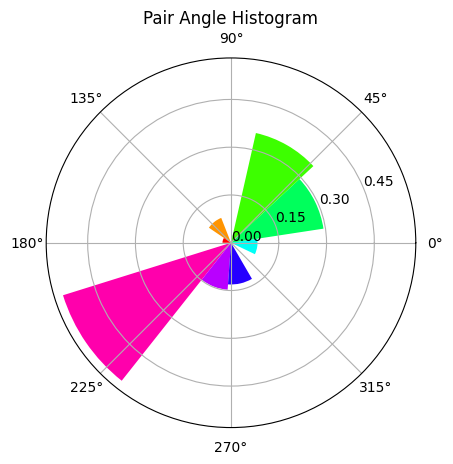

In [13]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True)

# <font color="brown">Figure Plot

In [30]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact
from matplotlib.ticker import MaxNLocator
import numpy as np


In [10]:

def plot_vector_layout2( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # organize pair directions
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=ms_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key].append( angles[i] )
        else:
            pair_dict[key] = [ angles[i] ]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2
        #angle2 = (angle2 + .5) % 1

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)

In [16]:
def plot_vector_layout3( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count
    pairs = good_pairs                      # make a copy of pairs, this avoids some bug
    latencies_count = []
    for i in range(len(pairs)):
        pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
        latencies_count.append(len(pair_latencies))
        if np.median(pair_latencies)<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
        else:
            pair_dict[key] = [ angles[i] ] * latencies_count[i]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)

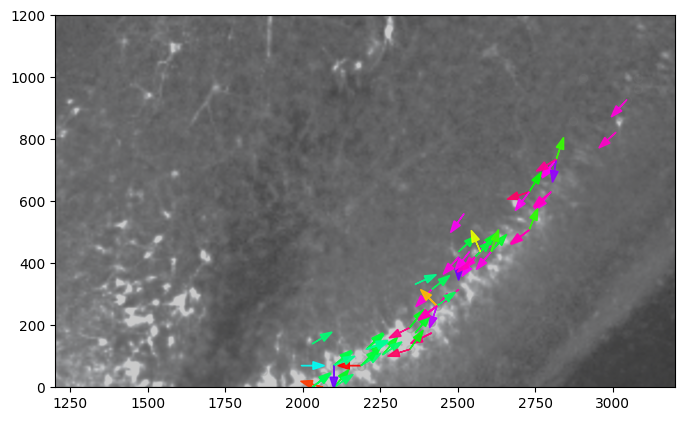

In [12]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

/tmp/ipykernel_4171/3376290751.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


/tmp/ipykernel_4171/3376290751.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


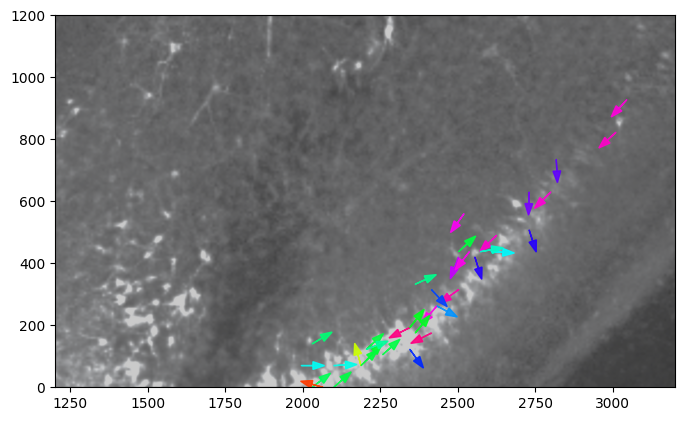

In [11]:
plot_vector_layout2( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

/tmp/ipykernel_4171/3919229163.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_4171/3919229163.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


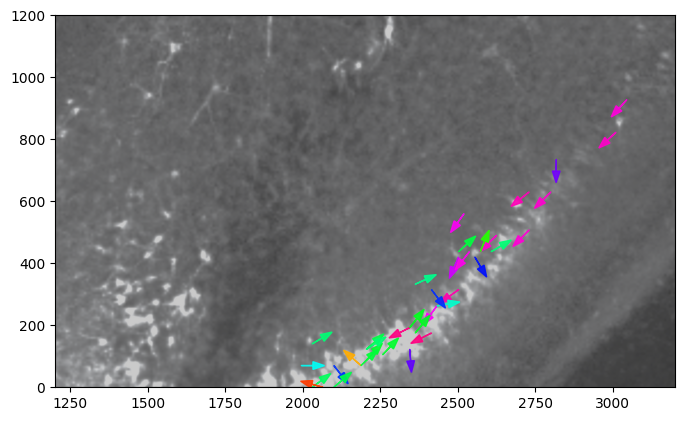

In [17]:
plot_vector_layout3( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

# <font color="brown"> Dig into Arrows

In [41]:
pairs= good_pairs
image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png"
xlim=(1200,3200)
ylim=(0,1200)
figsize=(8, 8)
ms_cutoff_high=20 
se_cuttoff = .1

In [53]:
def plot_vector_layout4( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20, se_cuttoff=.1 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count
    pairs = pairs                      # make a copy of pairs, this avoids some bug
    latencies_count = []
    for i in range(len(pairs)):
        pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
        latencies_count.append(len(pair_latencies))
        if np.median(pair_latencies)<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
        else:
            pair_dict[key] = [ angles[i] ] * latencies_count[i]

    # create new dictionary of just mean angles
    pair_angles = {}
    pair_se = {}
    for key, value in pair_dict.items():
        pair_angles[key] = sum(value) / len(value)
        pair_se[key] = np.std(value, ddof=1) / len(value)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_se[pair] < se_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SE cutoff:", pair_removed )


/tmp/ipykernel_4171/3022591660.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_4171/3022591660.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SE cutoff: 1


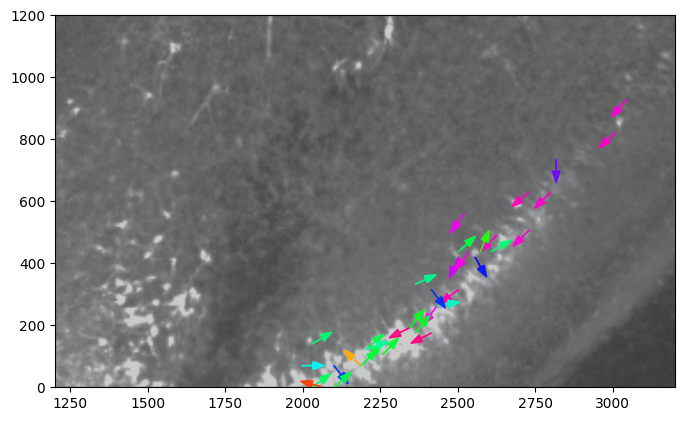

In [55]:
plot_vector_layout4( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                    xlim=(1200,3200), ylim=(0,1200), se_cuttoff=.1 )

/tmp/ipykernel_4171/3022591660.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_4171/3022591660.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SE cutoff: 3


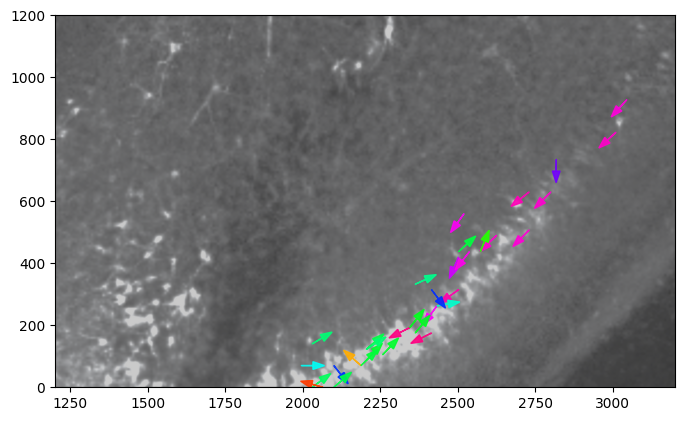

In [56]:
plot_vector_layout4( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                    xlim=(1200,3200), ylim=(0,1200), se_cuttoff=.02 )

# <font color="brown">Old Stuff 

(array([31.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.01099594, 0.02199187, 0.03298781, 0.04398374,
        0.05497968, 0.06597561, 0.07697155, 0.08796749, 0.09896342,
        0.10995936]),
 <BarContainer object of 10 artists>)

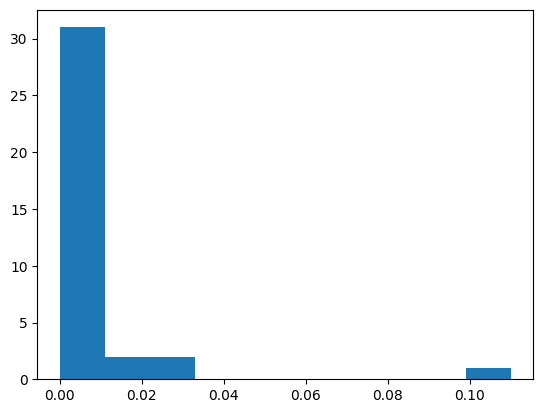

In [48]:
plt.hist( list(pair_se.values()) )

In [49]:
@interact(num=(0,35))
def angles_hist(num):
    key = list(pair_dict.keys())[num]
    print("SD:", np.std( pair_dict[key] ))
    print( "SE", np.std( pair_dict[key], ddof=1) / np.sqrt(len(pair_dict[key])) )
    plt.hist( pair_dict[key] )

interactive(children=(IntSlider(value=17, description='num', max=35), Output()), _dom_classes=('widget-interac…

1.4- iffy

/tmp/ipykernel_4171/402388530.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SE cutoff: 1


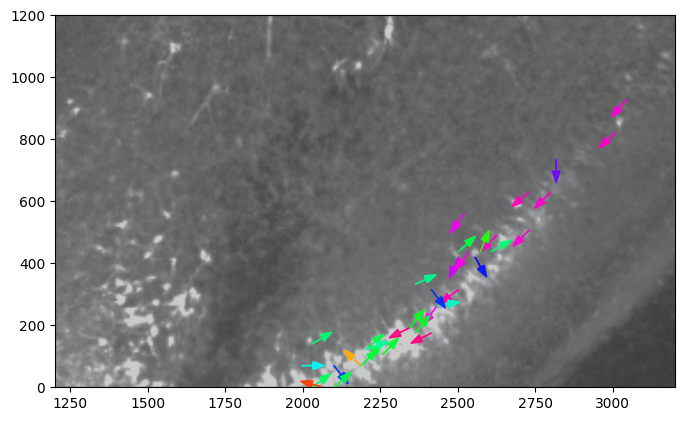

In [51]:


# Plot original scatter
plt.figure(figsize=(8, 8))
ax = plt.axes()
if image_path is not None:
    img = plt.imread(image_path)      # Load in image
    plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
plt.xlim( xlim )
plt.ylim( ylim )    

# Draw Arrows
cmap = cm.get_cmap('hsv')
pair_removed = 0
for pair, angle in pair_angles.items():
    if pair_se[pair] < se_cuttoff :
        angle2 = (angle*-1+ np.pi)/np.pi/2
        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)
    else:
        pair_removed = pair_removed + 1
print("Pairs removed by SE cutoff:", pair_removed )
